In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [32]:
# Cargar los datos de entrenamiento
data_clean = pd.read_csv('data_clean.csv')

In [33]:
# Convertir la columna 'Date' a tipo datetime
data_clean['Date'] = pd.to_datetime(data_clean['Date'], errors='coerce')

# Ordenar por fecha
data_clean.sort_values('Date', inplace=True)

In [34]:
# Dividir los datos en entrenamiento y prueba
train_end_date = '2015-05-30'
train_data = data_clean[data_clean['Date'] <= train_end_date]
test_data = data_clean[data_clean['Date'] > train_end_date]

In [35]:
# Función para cargar modelos y predecir usando Prophet
def load_and_predict_prophet(train_data, test_data):
    models = {}
    predictions = pd.DataFrame()

    for cluster in train_data['Cluster'].unique():
        cluster_train_data = train_data[train_data['Cluster'] == cluster].copy()
        cluster_test_data = test_data[test_data['Cluster'] == cluster].copy()

        # Preparar datos para Prophet
        cluster_train_data = cluster_train_data.groupby('Date').agg({'Sales': 'sum', 'Customers': 'sum'}).reset_index()
        cluster_train_data.rename(columns={'Date': 'ds', 'Sales': 'y'}, inplace=True)

        cluster_test_data = cluster_test_data.groupby('Date').agg({'Sales': 'sum', 'Customers': 'sum'}).reset_index()
        cluster_test_data.rename(columns={'Date': 'ds', 'Sales': 'y'}, inplace=True)

        # Cargar el modelo para el cluster
        model_file = f'best_prophet_model_cluster_{cluster}.pkl'
        model = joblib.load(model_file)
        models[cluster] = model

        # Hacer predicciones
        forecast = model.predict(cluster_test_data[['ds', 'Customers']])
        forecast['Cluster'] = cluster
        forecast['y'] = cluster_test_data['y'].values
        predictions = pd.concat([predictions, forecast[['ds', 'yhat', 'Cluster', 'y']]], ignore_index=True)

    return models, predictions

# Llamada a la función con los datos de entrenamiento y prueba
models, predictions = load_and_predict_prophet(train_data, test_data)


In [36]:
# Entrenar y predecir usando Prophet
models, predictions = load_and_predict_prophet(train_data, test_data)


In [37]:
# Evaluar el rendimiento del modelo
def evaluate_performance(predictions):
    performance = {}
    for cluster in predictions['Cluster'].unique():
        cluster_predictions = predictions[predictions['Cluster'] == cluster]
        mae = mean_absolute_error(cluster_predictions['y'], cluster_predictions['yhat'])
        rmse = np.sqrt(mean_squared_error(cluster_predictions['y'], cluster_predictions['yhat']))
        accuracy = 1 - np.mean(np.abs((cluster_predictions['y'] - cluster_predictions['yhat']) / cluster_predictions['y']))
        performance[cluster] = {'MAE': mae, 'RMSE': rmse, 'Accuracy': accuracy}
    return performance

performance = evaluate_performance(predictions)

# Convertir el diccionario de métricas a DataFrame
performance_df = pd.DataFrame(performance).T
performance_df


,MAE,RMSE,Accuracy
1,159518.551123,200917.652749,0.942232
0,187959.736550,243800.316725,0.911800
2,38046.767559,48412.112649,0.933190


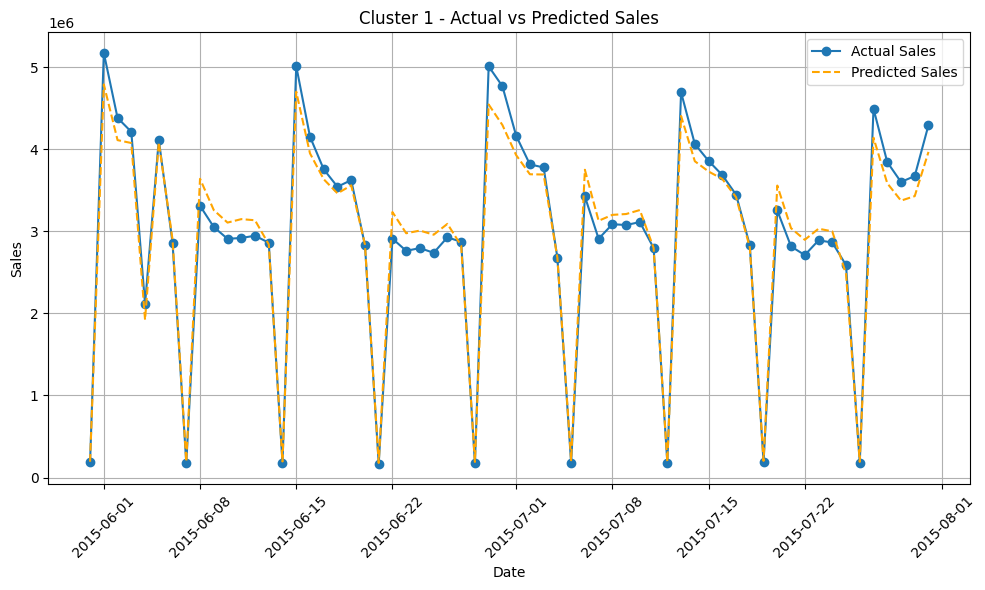

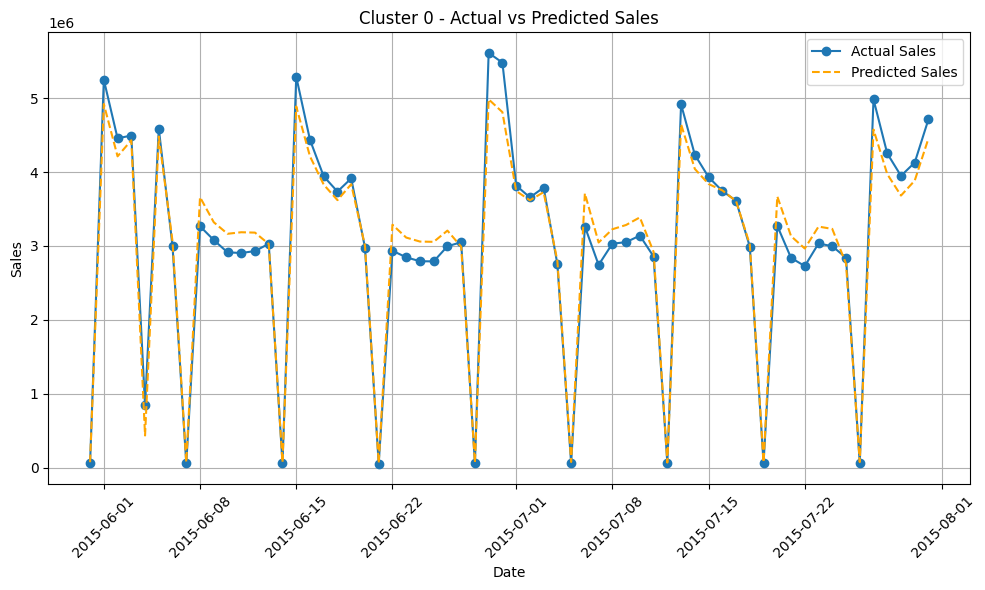

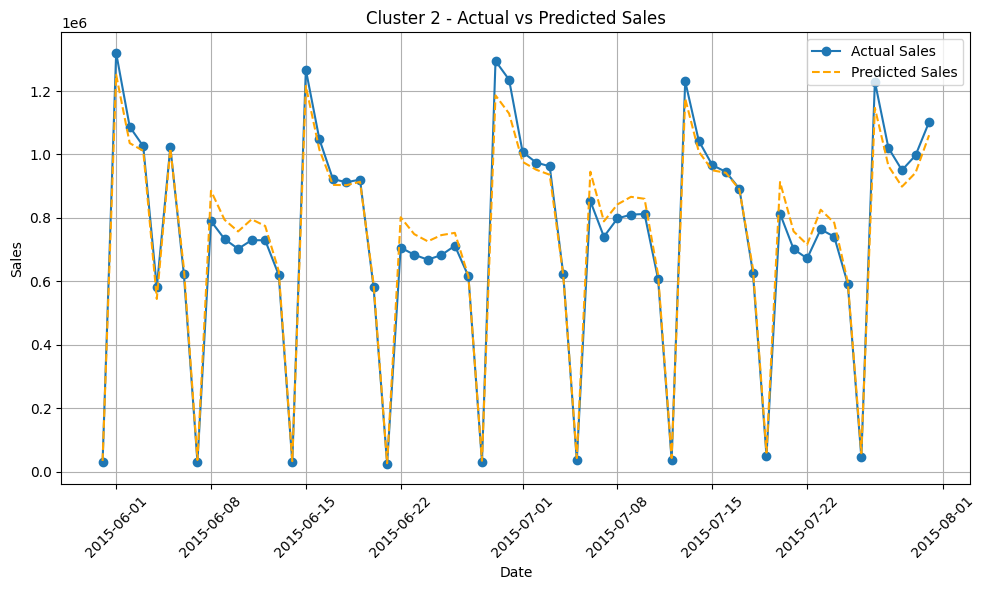

In [64]:
# Convertir 'ds' a datetime para mejor manejo en gráficos
predictions['ds'] = pd.to_datetime(predictions['ds'])

for cluster in predictions['Cluster'].unique():
    cluster_data = predictions[predictions['Cluster'] == cluster]
    plt.figure(figsize=(10, 6))
    plt.plot(cluster_data['ds'], cluster_data['y'], label='Actual Sales', marker='o', linestyle='-')
    plt.plot(cluster_data['ds'], cluster_data['yhat'], label='Predicted Sales', linestyle='--', color='orange')
    plt.title(f'Cluster {cluster} - Actual vs Predicted Sales')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
